In [152]:
from Functions.data_analysis import *
from Functions.edit_database import getTransactionData, getAccount
from Functions.variables import typeMapping
import numpy as np
from scipy.stats import linregress
import pandas as pd
import inspect
import sys

from matplotlib import pyplot as plt

plt.style.use('fivethirtyeight')

In [153]:
myAcc = getAccount("atlas")

myAcc.summary()

       Username: atlas
       Password: 1912766d6ba0e50e8b1bacfb51207e83b95b7ac0cd8ce15307cdf4965e7e3f6c
   Date Created: 2024-07-28 13:26:37
   Date Updated: 2024-07-28 13:26:37
        Balance: 10000000


In [154]:
df = getTransactionData(myAcc)

In [155]:
class enrichedData:
    def __init__(self, old_data:pd.DataFrame, data:pd.DataFrame, displacement:int = 0) -> None:
        self.old_data = old_data
        self.data = data
        self.displacement = displacement
        self.last_data = data.iloc[-1]
        self.filtered_data = {
            "DAY WEEK": self.filterData("DAY", "WEEK"),
            "DAY MONTH": self.filterData("DAY", "MONTH"),
            "DAY YEAR": self.filterData("DAY", "YEAR"),
            "WEEK MONTH": self.filterData("WEEK", "MONTH"),
            "WEEK YEAR": self.filterData("WEEK", "YEAR"),
            "MONTH YEAR": self.filterData("MONTH", "YEAR"),
            "QUARTER YEAR": self.filterData("QUARTER", "YEAR"),
            "YEAR YEAR": self.filterData("YEAR", "YEAR")
        }

    def __range__(self) -> None:
        print(f"{self.data.index.min()} - {self.data.index.max()}")

    def __length__(self) -> None:
        print(f"{len(self.data)} rows")

    def __functions__(self):
        methods = inspect.getmembers(self, predicate=inspect.ismethod)
        for name, method in methods:
            if name.startswith('__') and name.endswith('__'): continue
            docstring = method.__doc__
            print(f"Function: {name}")
            if docstring:
                print(f"  Docstring: {docstring.strip()}")
        
    def __size__(self):
        size = 0
        for attr_name, attr_value in self.__dict__.items():
            size += sys.getsizeof(attr_value)
        print(f"{size} bytes")

    @staticmethod
    def MAE(x, m, b, actual):
        return np.mean(abs(actual - (m * x + b)))
    
    @staticmethod
    def formatNumber(x: int) -> str:
        return f"{x:,}".replace(",", ".")
    
    def subtitle(self, index:str, group:str) -> str:
        x = int(self.last_data[("Features", group)] - self.displacement)

        if index == "YEAR":
            return "All Time"
        elif index == "MONTH" or group == "YEAR":
            return f"Year {int(self.last_data['Features', 'YEAR'])}"
        elif group != "YEAR":
            return f"{group.title()} {x}, Year {int(self.last_data['Features', 'YEAR'])}"

    def filterData(self, index:str, group:str):
        if index not in ["DAY", "WEEK", "MONTH", "QUARTER", "YEAR"]:
            raise ValueError("Invalid index. Allowed values are 'DAY', 'WEEK', 'MONTH', 'QUARTER', 'YEAR'.")
        if group not in ["DAY", "WEEK", "MONTH", "YEAR"]:
            raise ValueError("Invalid group. Allowed values are 'DAY', 'WEEK', 'MONTH', 'YEAR'.")
        if index == "DAY" and group not in ["WEEK", "MONTH", "YEAR"]:
            raise ValueError("Index is not in range.")
        elif index == "WEEK" and group not in ["MONTH", "YEAR"]:
            raise ValueError("Index is not in range.")
        elif index == "MONTH" and group not in ["YEAR"]:
            raise ValueError("Index is not in range.")
        elif index == "QUARTER" and group not in ["YEAR"]:
            raise ValueError("Index is not in range.")
        if index == "YEAR": group == "YEAR"
        

        DATA = self.data
        df = self.data
        if index != "YEAR":
            df = df[df[('Features', group)] == self.last_data[('Features', group)] - self.displacement]
            DATA = df[df[('Features', 'YEAR')] == self.last_data[('Features', 'YEAR')] - (self.displacement if group == "YEAR" else 0)]
        DATA = DATA.groupby(('Features', index)).sum()
        DATA.index.name = index

        return DATA

    def plotBoth(self, index:str, group:str):
        DATA = self.filtered_data[f"{index} {group}"]

        _, ax = plt.subplots(figsize=(20, 6))
        DATA['Revenue', 'TOTAL'].plot(kind='bar', ax=ax, label='Total Revenue', color='green', alpha=0.6)
        (-DATA['Expenses', 'TOTAL']).plot(kind='bar', ax=ax, label='Total Expenses', color='red', alpha=0.6)
        ax.set_title(f'Total Expenses and Revenue\n{self.subtitle(index, group)}', loc='center')
        ax.set_xlabel(index)
        ax.set_ylabel('Amount')
        ax.legend()
        plt.tight_layout()

    def plotTotal(self, index:str, group:str):
        DATA = self.filtered_data[f"{index} {group}"]

        _, ax = plt.subplots(figsize=(20, 6))
        DATA['TOTAL'].plot(kind='bar', ax=ax, label='Net Total', color='blue', alpha=0.6)
        # DATA['TOTAL'].plot(color='red', label='TOTAL')
        ax.set_title(f'Net Total\n{self.subtitle(index, group)}', loc='center')
        ax.set_xlabel(index)
        ax.set_ylabel('Amount')
        ax.legend()
        plt.tight_layout()
        plt.show()

    def plotCumulative(self, index:str, group:str):
        DATA = self.filtered_data[f"{index} {group}"]

        _, ax3 = plt.subplots(figsize=(20, 6))
        DATA['Revenue', 'TOTAL'].cumsum().plot(ax=ax3, label='Cumulative Revenue', color='green', alpha=0.6)
        DATA['Expenses', 'TOTAL'].cumsum().plot(ax=ax3, label='Cumulative Expenses', color='red', alpha=0.6)
        DATA['TOTAL'].cumsum().plot(ax=ax3, label='Budget', color='blue', alpha=0.6)
        ax3.set_title(f'Cumulative Data\n{self.subtitle(index, group)}', loc='center')
        ax3.set_xlabel(index)
        ax3.set_ylabel('Amount')
        ax3.legend()
        plt.tight_layout()

    def plotExpenses(self, index: str, group: str):
        DATA = self.filtered_data[f"{index} {group}"]

        _, ax4 = plt.subplots(figsize=(20, 6))
        DATA['Expenses', 'TOTAL'].cumsum().plot(ax=ax4, label='Cumulative Expenses', color='green', alpha=0.6)

        x = np.arange(len(DATA['Expenses', 'TOTAL'].cumsum())) + self.data.iloc[2]['Features', index]
        m, b = np.polyfit(x, np.array(DATA['Expenses', 'TOTAL'].cumsum()), 1)
        y_actual = np.array(DATA['Expenses', 'TOTAL'].cumsum())

        ax4.plot(x, m * x + b, label='Linear Regression')
        ax4.set_title(f'Cumulative Expenses\n{self.subtitle(index, group)}', loc='center')
        ax4.set_xlabel(index)
        ax4.set_ylabel('Amount')
        ax4.legend()

        mae_formatted = self.formatNumber(int(self.MAE(x, m, b, np.array(DATA['Expenses', 'TOTAL'].cumsum()))))
        m_formatted = self.formatNumber(int(m))
        b_formatted = self.formatNumber(int(b))
        ax4.text(
            x[len(x) // 2], m * x[len(x) // 2] + b - 0.3 * (max(y_actual) - min(y_actual)), 
            f"MAE: {mae_formatted}\nf(t) = {m_formatted}x + {b_formatted}\nRp. {m_formatted}/{index.lower()}", 
            fontsize=12, verticalalignment='bottom', horizontalalignment='left'
        )
        plt.tight_layout()

    def plotRevenue(self, index:str, group:str):
        DATA = self.filtered_data[f"{index} {group}"]

        _, ax5 = plt.subplots(figsize=(20, 6))
        DATA['Revenue', 'TOTAL'].cumsum().plot(ax=ax5, label='Cumulative Revenue', color='green', alpha=0.6)

        x = np.arange(len(DATA['Revenue', 'TOTAL'].cumsum())) + self.data.iloc[2]['Features', index]
        m, b = np.polyfit(x, np.array(DATA['Revenue', 'TOTAL'].cumsum()), 1)
        y_actual = np.array(DATA['Revenue', 'TOTAL'].cumsum())

        ax5.plot(x, m * x + b, label=f'Linear Regression')
        ax5.set_title(f'Cumulative Revenue\n{self.subtitle(index, group)}', loc='center')
        ax5.set_xlabel(index)
        ax5.set_ylabel('Amount')
        ax5.legend()

        mae_formatted = self.formatNumber(int(self.MAE(x, m, b, np.array(DATA['Revenue', 'TOTAL'].cumsum()))))
        m_formatted = self.formatNumber(int(m))
        b_formatted = self.formatNumber(int(b))
        ax5.text(
            x[len(x) // 2], m * x[len(x) // 2] + b - 0.3 * (max(y_actual) - min(y_actual)), 
            f"MAE: {mae_formatted}\nf(t) = {m_formatted}x + {b_formatted}\nRp. {m_formatted}/{index.lower()}", 
            fontsize=12, verticalalignment='bottom', horizontalalignment='left'
        )
        plt.tight_layout()

    def yearCube(self):
        year = self.last_data['Features', 'YEAR']
        DATA = self.filtered_data["DAY YEAR"]

        day = np.array(DATA['TOTAL'])
        day = np.pad(day, (0, 16 * 23 - len(day)), 'constant')
        day = day.reshape(16, 23)

        fig, ax = plt.subplots(figsize=(9, 6))
        cax = ax.imshow(day, aspect='auto', cmap='binary')
        fig.colorbar(cax)

        
        ax.set_title(f'Net Total Heatmap\nYear {int(year)}')

        plt.tight_layout()

    def records(self):
        total_expenses = self.data['Expenses', 'TOTAL'].sum()
        total_revenue = self.data['Revenue', 'TOTAL'].sum()

        average_expenses_day = self.data['Expenses', 'TOTAL'].mean()
        average_revenue_day = self.data['Revenue', 'TOTAL'].mean()

        average_expenses_week = self.data['Expenses', 'TOTAL'].resample('W').mean().mean() * 7
        average_revenue_week = self.data['Revenue', 'TOTAL'].resample('W').mean().mean() * 7

        average_expenses_month = self.data['Expenses', 'TOTAL'].resample('ME').mean().mean() * 31
        average_revenue_month = self.data['Revenue', 'TOTAL'].resample('ME').mean().mean() * 31
        
        average_expenses_quarter = self.data['Expenses', 'TOTAL'].resample('QE').mean().mean() * 93
        average_revenue_quarter = self.data['Revenue', 'TOTAL'].resample('QE').mean().mean() * 93
        
        average_expenses_year = self.data['Expenses', 'TOTAL'].resample('YE').mean().mean() * 365
        average_revenue_year = self.data['Revenue', 'TOTAL'].resample('YE').mean().mean() * 365

        net_savings = total_revenue - total_expenses

        savings_rate = (net_savings / total_revenue) * 100 if total_revenue != 0 else 0

        expense_rate = (total_expenses / total_revenue) * 100 if total_revenue != 0 else 0

        return {
            "expense": [total_expenses, average_expenses_day, average_expenses_week, average_expenses_month, average_expenses_quarter, average_expenses_year],
            "revenue": [total_revenue, average_revenue_day, average_revenue_week, average_revenue_month, average_revenue_quarter, average_revenue_year],
            "budget": net_savings,
            "rate": [expense_rate, savings_rate]
        }

    def _plotAll(self, index:str, group:str):
        self.plotBoth(index, group)
        self.plotTotal(index, group)
        self.plotCumulative(index, group)
        self.plotExpenses(index, group)
        self.plotRevenue(index, group)
        self.yearCube()

In [156]:
def enrichData(df: pd.DataFrame) -> enrichedData:
    old_data = df.copy()
    def WoM(dt):
        """ Returns the week of the month for the specified date. """
        first_day = dt.replace(day=1)
        dom = dt.day
        adjusted_dom = dom + first_day.weekday()
        
        return int(np.ceil(adjusted_dom / 7.0))

    df['UPDATED_AT'] = pd.to_datetime(df['UPDATED_AT'])
    df = df.drop(columns=['CREATED_AT', 'TRANSACTION_ID', 'ITEM', 'USERNAME']).set_index('UPDATED_AT').sort_index()
    
    
    expenses = pd.concat([
        df[(df['CATEGORY'] == 0) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 0]['TYPE'].unique()
    ], axis=1)

    
    revenue = pd.concat([
        df[(df['CATEGORY'] == 1) & (df['TYPE'] == i)]
        .drop(columns=['CATEGORY', 'TYPE'])
        .resample('D')
        .sum()
        .rename(columns={'VALUE': f'{i}'})
        for i in df[df['CATEGORY'] == 1]['TYPE'].unique()
    ], axis=1)

    expenses = expenses.reindex(sorted(expenses.columns, key=lambda x: int(x)), axis=1)
    revenue = revenue.reindex(sorted(revenue.columns, key=lambda x: int(x)), axis=1)


    expenses.columns = pd.MultiIndex.from_product([['Expenses'], expenses.columns])
    revenue.columns = pd.MultiIndex.from_product([['Revenue'], revenue.columns])

    expenses[('Expenses', 'TOTAL')] = expenses.sum(axis=1)
    revenue[('Revenue', 'TOTAL')] = revenue.sum(axis=1)


    features = pd.DataFrame(index=expenses.index.union(revenue.index))
    features[("Features", "DoW")] = features.index.day_of_week
    features[("Features", "DoM")] = features.index.day
    features[("Features", "WoM")] = features.index.map(WoM)
    features[("Features", "DAY")] = features.index.day_of_year
    features[("Features", "WEEK")] = features.index.isocalendar().week
    features[("Features", "QUARTER")] = features.index.quarter
    features[("Features", "MONTH")] = features.index.month
    features[("Features", "YEAR")] = features.index.year

    DATA = pd.concat([expenses, revenue, features], axis=1).fillna(0)
    
    DATA.index.name = "DATE"
    DATA['TOTAL'] = DATA['Revenue', 'TOTAL'] - DATA['Expenses', 'TOTAL']

    return enrichedData(old_data, DATA)


In [165]:
myData = enrichData(df)

myData.records()

{'expense': [3290644000.0,
  375430.00570450653,
  2626810.720936419,
  11601942.833481573,
  35010345.18517412,
  137056335.70715487],
 'revenue': [3469000000.0,
  395778.66514546494,
  2768555.466879489,
  12270126.630633095,
  36779663.19610341,
  144462158.3448428],
 'budget': 178356000.0,
 'rate': [94.85857595848948, 5.141424041510522]}

In [158]:
myData.__range__()
myData.__length__()
myData.__size__()
myData.__functions__()

2000-01-01 00:00:00 - 2023-12-30 00:00:00
8765 rows
29204487 bytes
Function: _plotAll
Function: filterData
Function: plotBoth
Function: plotCumulative
Function: plotExpenses
Function: plotRevenue
Function: plotTotal
Function: records
Function: subtitle
Function: yearCube


In [159]:
# myData.change_displacement(3)
# myData.showBoth("MONTH", "YEAR")

In [160]:
# myData.showExpenses("DAY", "YEAR")

In [161]:
# myData.showRevenue("DAY", "YEAR")

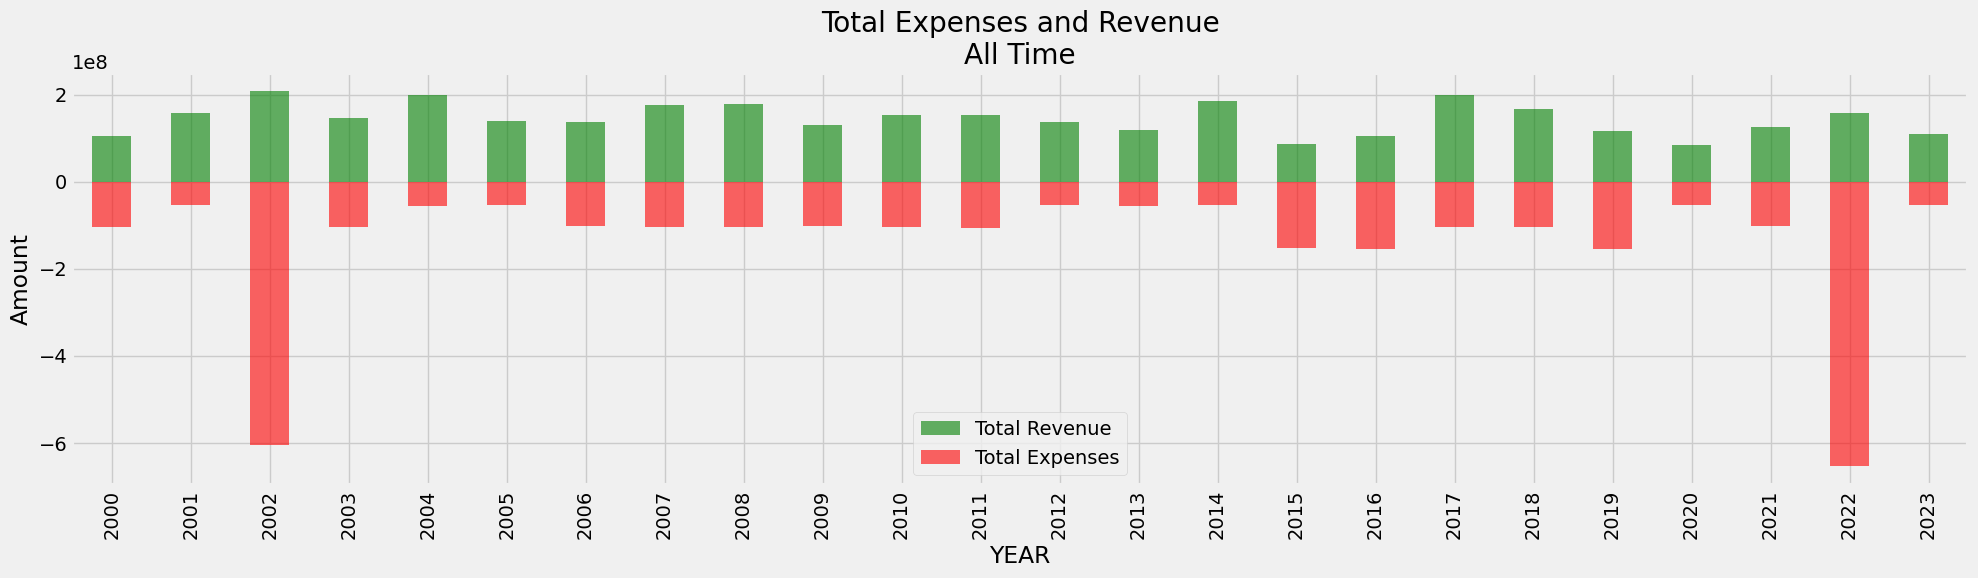

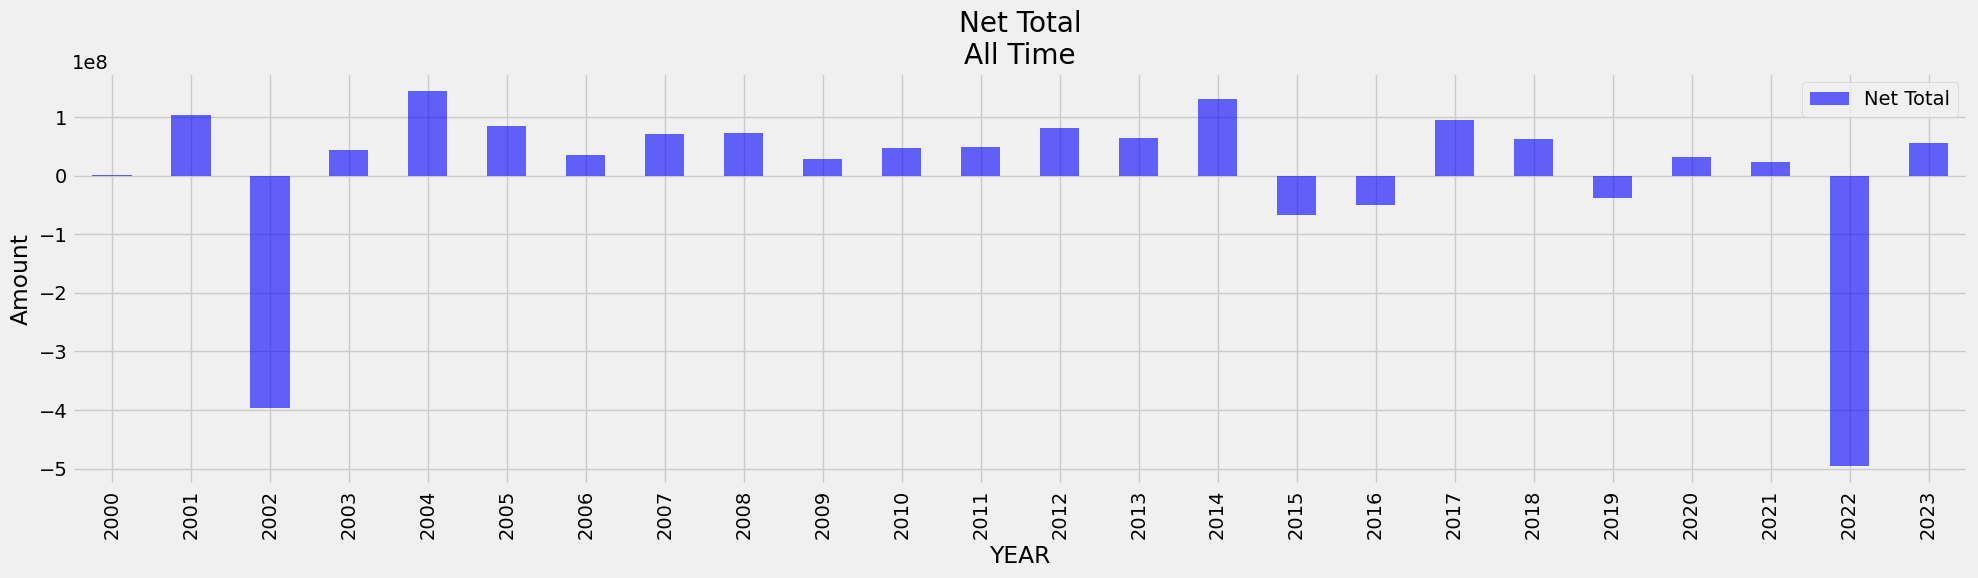

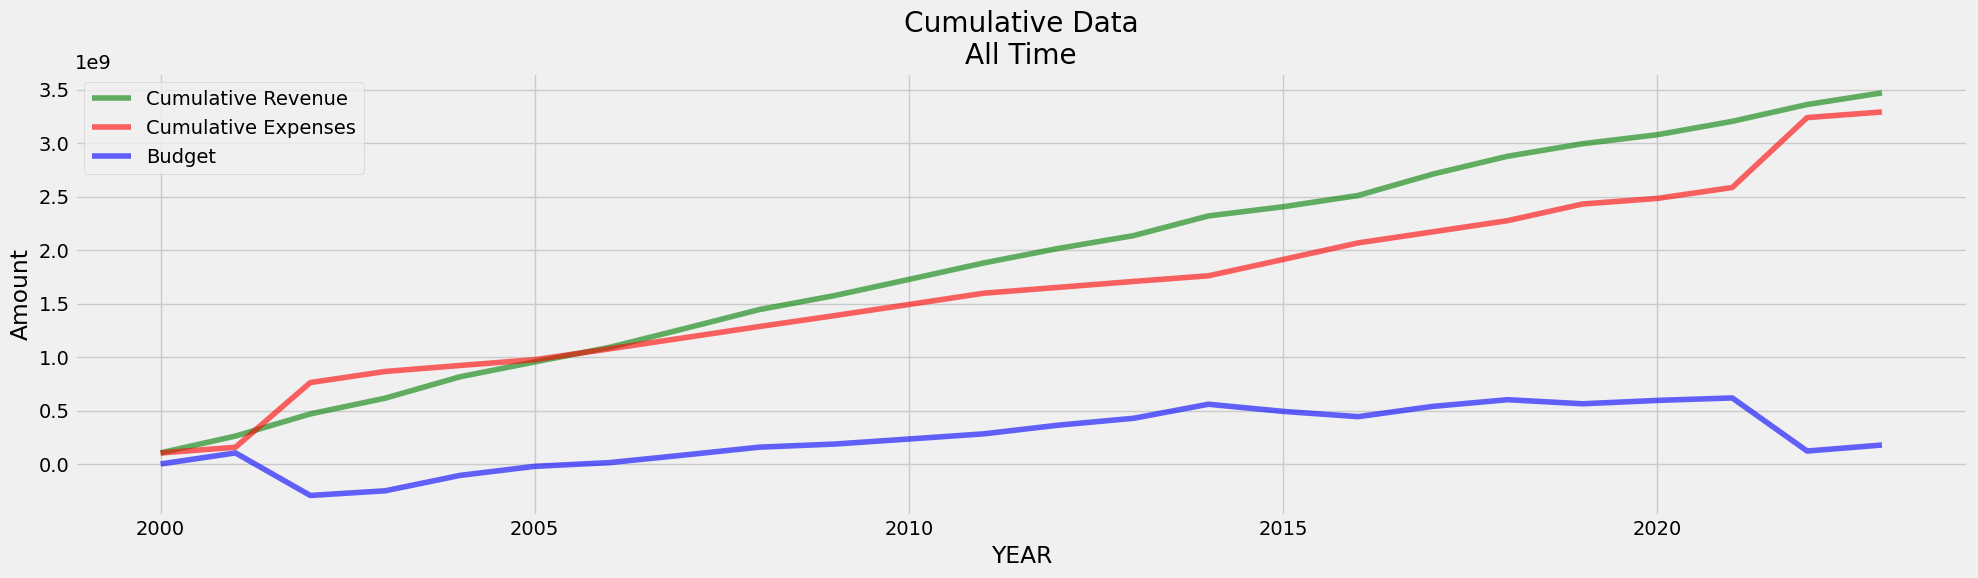

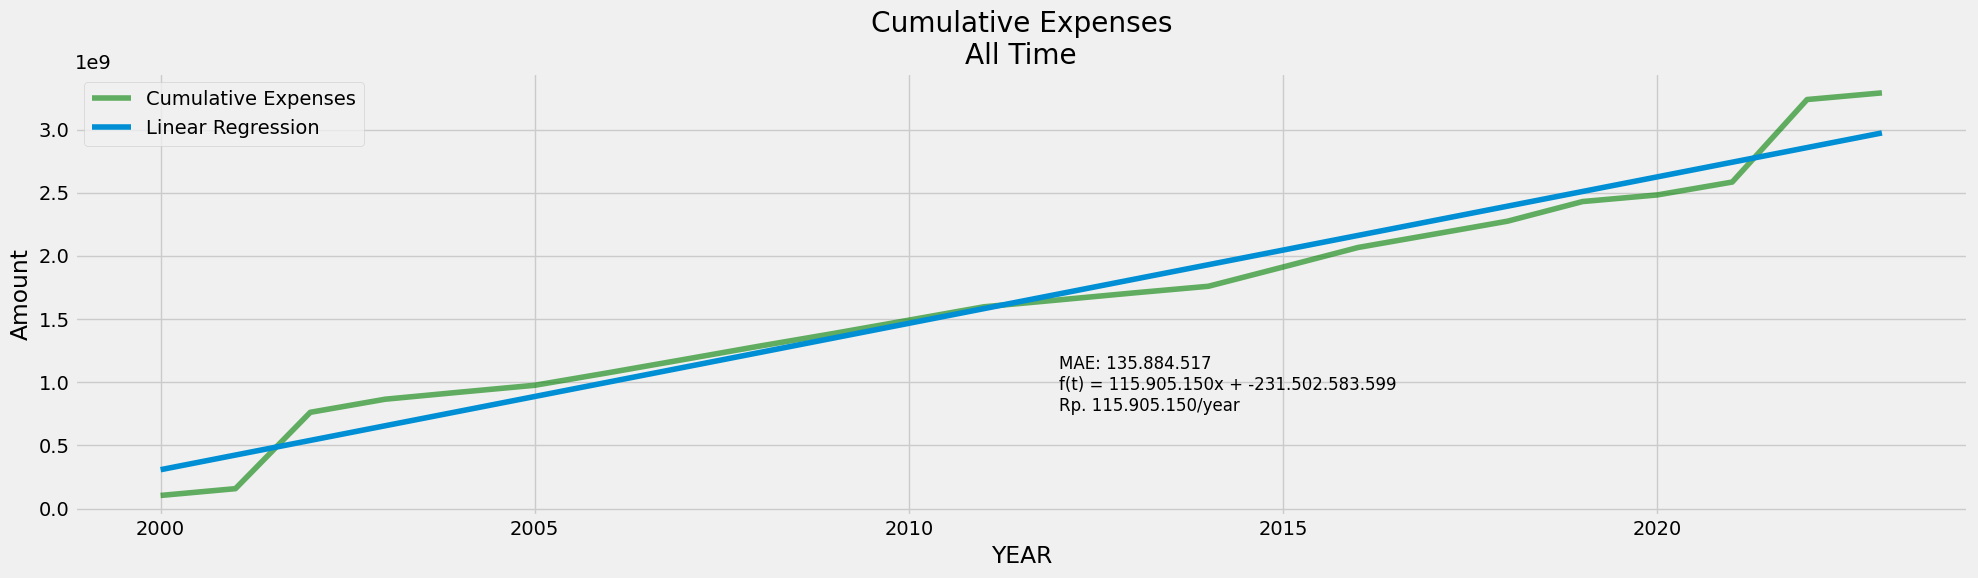

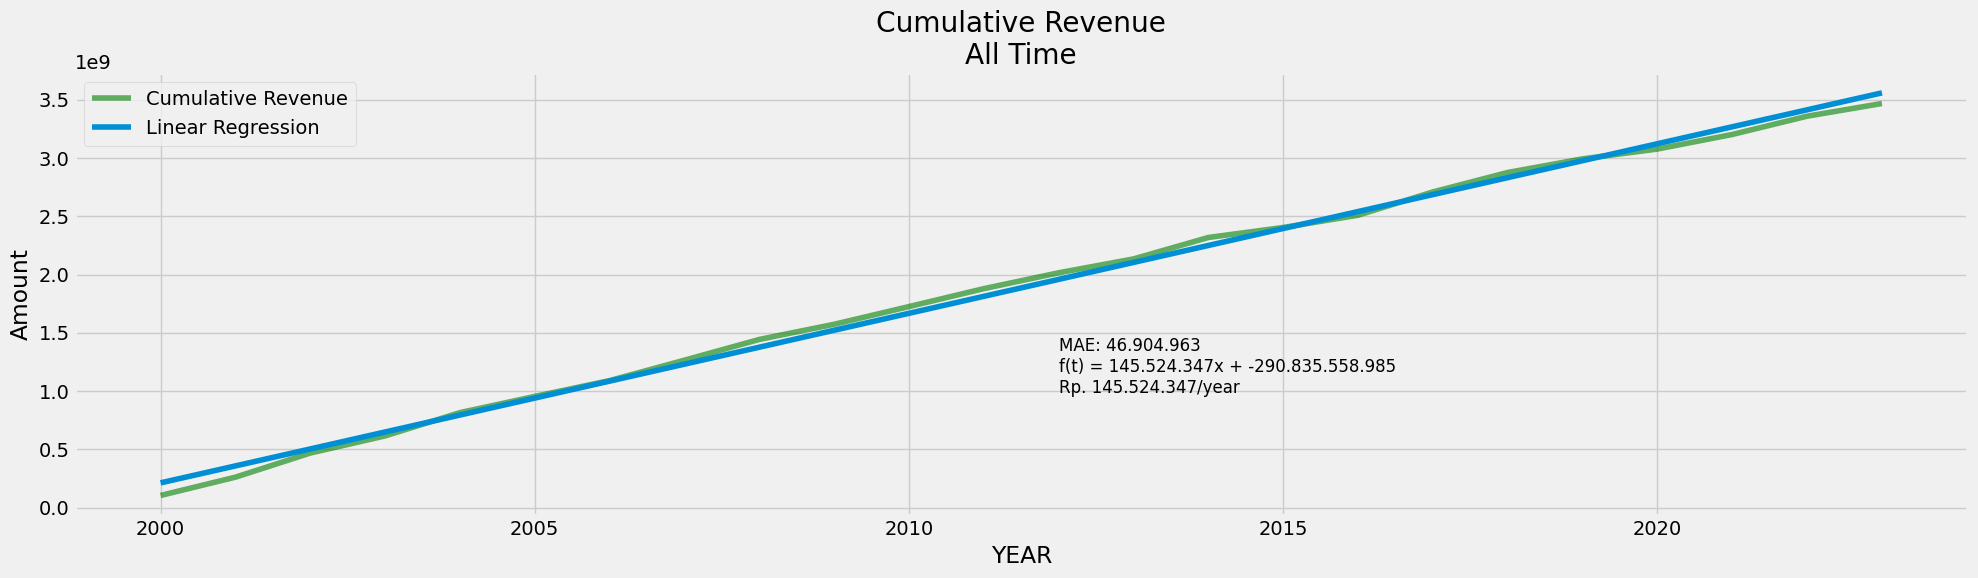

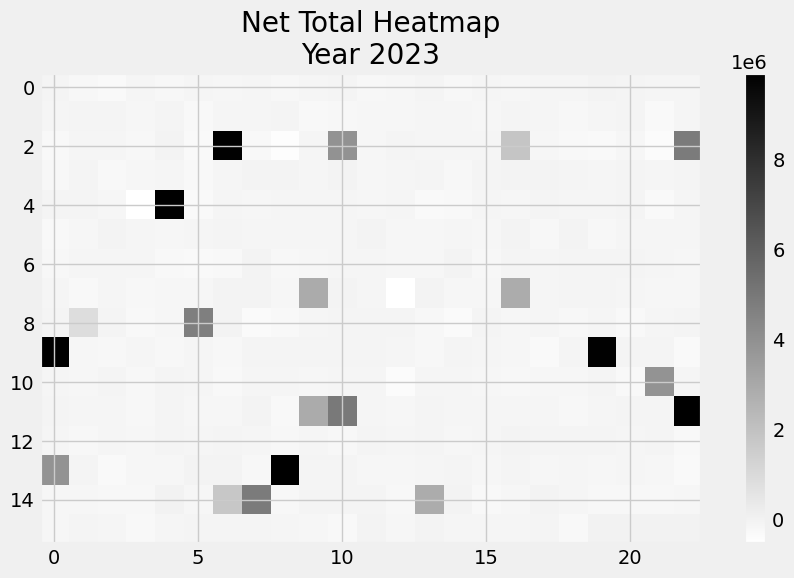

In [162]:
myData._plotAll("YEAR", "YEAR")